# TIME SERIES DECODER ONLY TRANSFORMER



In [107]:
# IMPORTS:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
from transformer_components import *
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

# References: 
# https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch

## Define transformer 

In [108]:

class Decoder_Transformer(nn.Module):
    def __init__(self,setups, vars, input_dim, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Decoder_Transformer, self).__init__()
        #self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model) #REMOVE EMBEDDING LAYER
        self.embedding = nn.Linear(vars, d_model)
        self.d_model = d_model
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length,setups)
        self.decoder_layers = nn.ModuleList([OnlyDecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, 1)
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model
        self.input_vars = vars
        self.num_heads = num_heads

    def generate_mask(self, tgt):
        #tgt_mask = (tgt != 0).unsqueeze(3)
        #print('target', tgt)
        # print('target mask',tgt_mask.shape,tgt_mask)
        
        seq_length = tgt.size(-1)
        # print('seq leng', seq_length)
        nopeak_mask = (1 - torch.triu(torch.ones(1,self.num_heads, seq_length, seq_length), diagonal=1)).bool()
        #print(nopeak_mask)
        # print('no peak mask',nopeak_mask.shape)
        
        # tgt_mask = tgt_mask & nopeak_mask
        # print('mask',tgt_mask)
        
        
        return nopeak_mask

    def forward(self, tgt):
        #print('tgt shape', tgt.shape)
        # emb = np.zeros((tgt.shape[0], self.d_model, tgt.shape[2]))
        # print('embedding shape',emb.shape)
        # for i in range(tgt.shape[0]):
        #     emb[i,:,:] = self.embedding(tgt[i,:,:])
        tgt = self.embedding(tgt.transpose(1,2)).transpose(1,2)
        #print('embedding',tgt.shape)
        
        tgt_mask = self.generate_mask(tgt)
        #print("tgt mask",tgt_mask.shape)
        # print('pos enc', self.positional_encoding(tgt))
        tgt_embedded = self.dropout(self.positional_encoding(tgt))
        

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, tgt_mask)

        # print('dec output', dec_output.shape,dec_output)
        # print('dec output[:, -1, :]', dec_output[:, -1, :].shape,dec_output[:, -1, :])
        output = self.fc(dec_output[:, -1, :])
        return output

## Prepare Data

Data is generated from an optimal control problem with input var x and control var u subject to

    dx/dt = 1 + u(t)**2
    x(0) = 1

Data is generated using the follwoing functions: 

Function 1 (optimal): 
    u = 1/(2*(2-t)), 
    x = t + 1/(8-(4*t))

Function 2:
    u = 1/t, 
    x = t - (1/t)
   
Function 3:
    u = 2*t, 
    x = t + (4*(t**3))/3

<img src="images\toy_pos_control_all_funcs.jpg" alt="drawing" width="500"/> 
<img src="images\toy_pos_control_func_13.jpg" alt="drawing" width="500"/> 

<img src="images\toy_dxdt_all_funcs.jpg" alt="drawing" width="500"/> 
<img src="images\toy_dxdt_funcs_13.jpg" alt="drawing" width="500"/> 

In [109]:
# Define data processing parameters
num_setups = 3      # number of different u functions used to generate data
split_time = 0.5   # time to split data from a scale of 0 to 1

In [110]:
# Read data file
df = pd.read_csv("data.csv",sep=',', header=0,index_col=False)

# Replace inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)  

# Forward fill NaNs (fill with last valid value)
df.fillna(method='ffill', inplace=True)  

# Split timeseries data into training and test data
df['ID'] = df['ID'].astype(int)
train_data = df[df['time'] < split_time]  
test_data = df[df['time'] >= split_time]  

# Select position and control columns
train_array = train_data[['u', 'ID']]
test_array = test_data[['u','ID']]
# train_array = train_data[['x']]
# test_array = test_data[['x']]

print('train shape: ', train_array.shape)
print('test shape:  ', test_array.shape)
#Make noisey to test data
#test_array['x'] = 10*(np.exp( np.linspace(0,1,num=150))+ 7*np.random.rand(test_array.shape[0]))
#print(test_array.shape) 

# Rescale data
scaler = StandardScaler() #rescale z = (x - mean) / std --> mean 0 std of 1
scaled_train_data = train_array.to_numpy()  #scaler.fit_transform(train_array)#.flatten().tolist()
scaled_test_data = test_array.to_numpy()  #scaler.transform(test_array)#.flatten().tolist()

# Print
print('df: \n',df.shape,df.head())
print('scaled train shape: ', scaled_train_data.shape)
print('scaled test shape:  ', scaled_test_data.shape)

train shape:  (75000, 2)
test shape:   (75000, 2)
df: 
 (150000, 4)       time         u         x  ID
0  0.00000  0.250000  0.125000   1
1  0.00002  0.250003  0.125021   1
2  0.00004  0.250005  0.125043   1
3  0.00006  0.250008  0.125064   1
4  0.00008  0.250010  0.125085   1
scaled train shape:  (75000, 2)
scaled test shape:   (75000, 2)


[0.66667778 0.6667     0.66672222 ... 1.24995    1.249975   1.25      ]
(3, 25000)


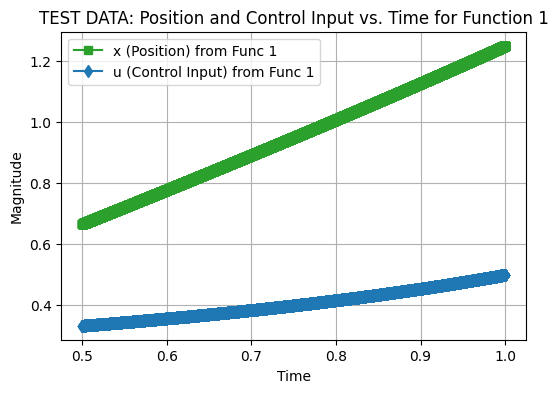

KeyboardInterrupt: 

In [111]:
# Select position and control columns
plot_train_array = train_data[['x', 'u']]
plot_test_array = test_data[['x', 'u']]
train_time = train_data[['time']]
test_time = test_data[['time']]


#Make noisey to test data
#test_array['x'] = 10*(np.exp( np.linspace(0,1,num=150))+ 7*np.random.rand(test_array.shape[0]))
#print(test_array.shape) 

# Reshape test and train arrays
plot_train_array = plot_train_array.to_numpy().reshape(num_setups, plot_train_array.shape[0]//num_setups,2)
plot_test_array = plot_test_array.to_numpy().reshape(num_setups, plot_test_array.shape[0]//num_setups,2)
#test_array = test_array.reshape(num_setups, test_array.shape[0]//num_setups,2)
train_time = train_time.to_numpy().reshape(num_setups,  train_time.shape[0]//num_setups)
test_time = test_time.to_numpy().reshape(num_setups,  test_time.shape[0]//num_setups)

print(plot_test_array[0,:,0])
print(test_time.shape)

for i in range(num_setups):
    plt.figure(i,figsize=(6, 4))
    plt.plot(test_time[0], plot_test_array[i,:, 0], 's-',color='C2', label=f'x (Position) from Func {i+1}')
    plt.plot(test_time[0], plot_test_array[i,:, 1], 'd-',color='C0', label=f'u (Control Input) from Func {i+1}')
    
    plt.title(f'TEST DATA: Position and Control Input vs. Time for Function {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:

# Reshape test and train arrays
vars = 2
train_array = scaled_train_data.reshape(num_setups, scaled_train_data.shape[0]//num_setups,vars)
test_array = scaled_test_data.reshape(num_setups, scaled_test_data.shape[0]//num_setups,vars)


# Print results
# print('train: ', train_array)
#print('test:  ', test_array)
print('train shape: ', train_array.shape)
print('test shape:  ', test_array.shape)

# #print('train data: ',train_array)
# for i in range(plot_train_array.shape[0]):
#     plt.figure(i,figsize=(6, 4))
#     plt.plot(test_time[0], test_array[i,:, 1], 's-',color='C2', label=f'x (Position) from Func {i+1}')
#     plt.plot(test_time[0], test_array[i,:, 2], 'd-',color='C0', label=f'u (Control Input) from Func {i+1}')
    
#     plt.title(f'SCALED TEST DATA: Position and Control Input vs. Time for Function {i+1}')
#     plt.xlabel('Time')
#     plt.ylabel('Magnitude')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

train shape:  (3, 5000, 2)
test shape:   (3, 5000, 2)


In [ ]:
# def create_sequences(data, sequence_length):
#     inputs_var = []
#     targets_var =[]
#     inputs_u = []
#     targets_u =[]
#     inputs_setup = []
#     targets_setup =[]
#     inputs=[]
#     targets=[]
    
#     for setup in range(data.shape[0]):
#         #print('setup',setup)
#         # print('input', setup[:,:sequence_length-pred_length])
#         # print('target', setup[:,pred_length:])

#         # inputs.append(setup[:sequence_length-pred_length,:])
#         # ##targets.append(setup[pred_length:sequence_length:,:]) # predict only u values
#         # targets.append(setup[pred_length:,:])
#         #print('setup:', setup)
#         inputs_var = []
#         targets_var =[]
        
#         for i in range(data.shape[1] - sequence_length):
#             inputs = []
#             targets = []
            
#             for j in range(data.shape[2]):
#                 setup_var = data[setup,:,j]
#                 #print(j, setup_var)
#                 window = setup_var[i:(i + sequence_length)] # take a window starting at i with size seq len (input x)
#                 after_window = setup_var[ i + sequence_length] # value after window (predicted val y)

#                 inputs.append(window)
#                 targets+=[[after_window]]
#                 #print('inputs',inputs)
            
#             inputs_var+=[inputs]
#             targets_var+=[targets]  
#             #print('input_vars', inputs_var)
        
#         inputs_setup.append(inputs_var)
#         targets_setup.append(targets_var)

#     return np.array(inputs_setup), np.array(targets_setup)

def create_sequences(data, sequence_length):
    inputs, targets = [], []
    for setup in [0]:#range(data.shape[0]):
        for i in range(data.shape[1] - sequence_length):
            inputs.append(data[setup, i:i+sequence_length, :])
            targets.append(data[setup, i+sequence_length, :])
    return np.array(inputs), np.array(targets)


# Create sequences 
#pred_length = 30   # e.g. pred_length=2 --> data: [1,2,3,4,5], x = [1,2,], y = [3,4,5]
# with train shpae 50 and pred_length 30 --> x_train: 0:20 and y_train: 30:50 (no overlap)
### ADD VISUALISATION OF DATA SEQUENCES
sequence_len = 10
num_setups = 1
x_train, y_train = create_sequences(train_array,sequence_len )
x_test, y_test = create_sequences(test_array,sequence_len )

# Print results
# x_train = x_train.reshape(x_train.shape[0]*x_train.shape[1],x_train.shape[2],x_train.shape[3] )
# y_train = y_train.reshape(y_train.shape[0]*y_train.shape[1],y_train.shape[2], y_train.shape[3])

# x_test = x_test .reshape(x_test.shape[0]*x_test.shape[1],x_test.shape[2],x_test.shape[3] )
# y_test  = y_test .reshape(y_test.shape[0]*y_test.shape[1],y_test.shape[2], y_test.shape[3])

# x_train = x_train.reshape(x_train.shape[0],x_train.shape[2],x_train.shape[1] )
# y_train = y_train.reshape(y_train.shape[0],y_train.shape[2], y_train.shape[1])

# x_test = x_test.reshape(x_test.shape[0],x_test.shape[2],x_test.shape[1] )
# y_test  = y_test.reshape(y_test.shape[0],y_test.shape[2], y_test.shape[1])

#print('num setups: ',num_setups)
print('x train shape: ', x_train.shape)
print('y train shape: ', y_train.shape)
print('x test shape: ', x_test.shape)
print('y test shape: ', y_test.shape)
# print('x_train: ', x_train)
# print('y train: ', y_train)

y_train = y_train[:,0]
y_test = y_test[:,0]
# print('x test: ', x_test)
#print('y test: ', y_test)
#print('y train: ', y_train)
print('x test shape: ', y_train.shape)
print('y test shape: ', y_test.shape)

x train shape:  (4990, 10, 2)
y train shape:  (4990, 2)
x test shape:  (4990, 10, 2)
y test shape:  (4990, 2)
x test shape:  (4990,)
y test shape:  (4990,)


In [ ]:
# Convert test and train data to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).transpose(1,2)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).transpose(1,2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
# x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
# x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=False) #train_dataset
test_dataloader = DataLoader(test_dataset, batch_size=y_test.shape[0]//num_setups, shuffle=False)

#Print
print('x train shape: ', x_train_tensor.shape) #shape: num setups, num inputs, length sequence
print('y train shape: ', y_train_tensor.shape)
print('x test shape: ', x_test_tensor.shape)
print('y test shape: ', y_test_tensor.shape)

#print('x train: ', x_train_tensor) #shape: num setups, num inputs, length sequence
# print('y train: ', y_train_tensor)
# print('x test: ', x_test_tensor)
# print('y test: ', y_test_tensor)

x train shape:  torch.Size([4990, 2, 10])
y train shape:  torch.Size([4990])
x test shape:  torch.Size([4990, 2, 10])
y test shape:  torch.Size([4990])


## Set Transformer Parameters

In [ ]:

# define transformer size
d_model = 16                           # dimension of data 2 --> x,u
num_heads = 1                           # number of attention heads for multihead attention
num_layers = 1                         # number of decoder layers
d_ff = 100                              # size of feed forward neural network

# define parameters
max_seq_length = max(x_train_tensor.shape[-1],x_test_tensor.shape[-1])   # maximum sequence length 
print(max_seq_length)
dropout = 1                         # dropout
setups = train_array.shape[0]           # number of setups
#tgt_vocab_size = 5                     # for embedding but embedding not used

# create transformer
transformer = Decoder_Transformer(setups, vars,sequence_len, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

10


# Train Transformer

In [ ]:
# define parameters
criterion = nn.MSELoss() #loss criteria
optimizer = optim.Adam(transformer.parameters(),lr=1e-3, betas=(0.9, 0.98), eps=1e-9)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True) #This dynamically adjusts the learning rate based on the number of epochs and can lead to better training stability and performance.

EPOCH = 200
STOP_EARLY = True #false --> no early stopping
stop_count = 20   # if the loss increases stop_count times in a row, stop early

c:\Users\sian_\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
# training loop


early_stop_count = 0
min_val_loss = float('inf')
train_losses = []
device = 'cpu'
test_losses=[]
val_outputs = []
val_inputs = []
val_ys = []
val_losses = []
for epoch in range(EPOCH):
    train_loss = 0
    transformer.train()
    for batch in train_dataloader: #for each batch
        #y=y.transpose(1,2).squeeze(1)
       
        #output = transformer(x, y[:, :-1]) #eclude last token from target
        #print('x', x.shape, x)
        x, y = batch
        x, y = x.to('cpu'), y.to('cpu')
        optimizer.zero_grad()
        output = transformer(x)
        
        # print('x', x.shape, x)
        # print('y', y.shape) #, y)
        # print('output',output.shape)#, output)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        val_outputs.append(output)
        val_inputs.append(x)
        val_ys.append(y)
    
    # train_loss /= len(train_dataloader)
    # train_losses.append(train_loss)
    
    with torch.no_grad():
        for batch in test_dataloader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = transformer(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    #print(f"Epoch: {epoch+1}, Loss: {loss.item()}, Avg Loss of batch: {train_loss}")
    if early_stop_count >= stop_count and STOP_EARLY:
        print("Stopping: Loss increasing")
        break
print(f"Epoch: {epoch+1}, Loss: {loss.item()}, Val. Loss: {val_loss}")

c:\Users\sian_\anaconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\sian_\anaconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4990])) that is different to the input size (torch.Size([4990, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Stopping: Loss increasing
Epoch: 22, Loss: 0.007479285821318626, Val. Loss: 0.007460691500455141


In [ ]:
#Metrics function 1 --> batch 1
from sklearn.metrics import mean_squared_error, r2_score
print(len(val_outputs))
print(val_outputs[0].shape)
print(val_ys[0].shape)

# Undo rescaling
for i in range(num_setups): 
    print(i)
    val_outputs[i] = val_outputs[i].detach().numpy().transpose(0,1)#scaler.inverse_transform(val_outputs[i].detach().numpy())
    val_ys[i] = val_ys[i].detach().numpy()#.transpose(0,1)#scaler.inverse_transform(val_ys[i].detach().numpy())

print(val_outputs[0].shape)
print(val_ys[0].shape)



10978
torch.Size([10, 1])
torch.Size([10])
0
(10, 1)
(10,)


In [ ]:
# test_array_tensor = torch.tensor(test_array, dtype=torch.float32)
# #print(val_outputs[0]-val_ys[0])
# # print(val_ys)
# # print(y_train)
# print(val_outputs[-1].shape)
# #print('full test sequence',test_array_tensor)

# function = 1
# rmse, r_squared = rmse_r2(val_outputs[function-1], val_ys[function-1], f'Function {function}')
# # plot_predictions_vs_actual(val_outputs[0].squeeze(0),val_inputs[0].transpose(1,2).squeeze(0),test_array_tensor[0,:,:], f'Func 1: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})')
# plot_predictions_vs_actual_simple(val_outputs[function-1], val_ys[function-1], f'Function {function}: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})')

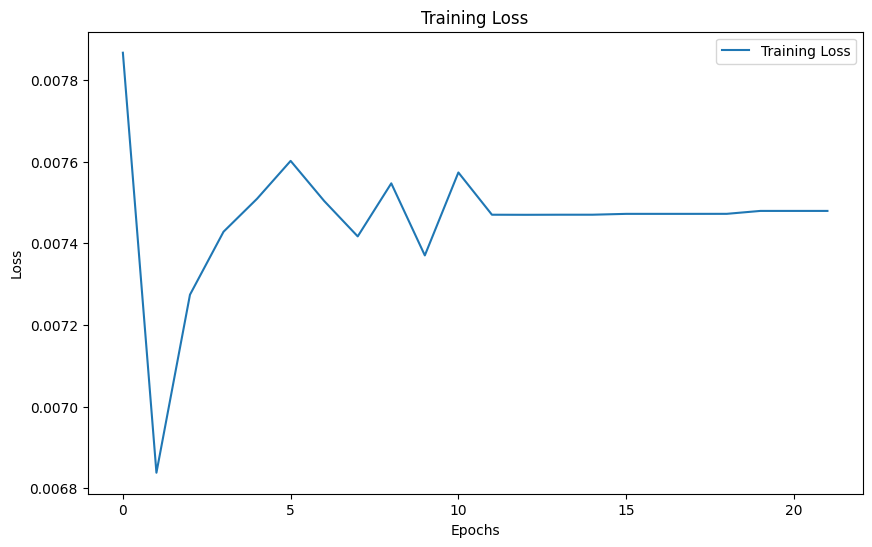

In [ ]:
#Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(val_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Test Transformer

In [ ]:
# testing loop
transformer.eval()

#test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=False)
test_losses=[]
val_outputs = []
val_inputs = []
val_ys = []
i = 0
with torch.no_grad():
    test_loss=0
    
    for x, y in test_dataloader:
        print(i+1)
        i += 1
        
        # print(x.shape)
        # print(y.shape)
        val_output = transformer(x)
        #val_y=y.transpose(1,2).squeeze(1)
        val_y = y
        
        val_outputs.append(val_output)
        val_inputs.append(x)
        val_ys.append(val_y)
    
    
print(val_outputs[0].shape)
print(val_ys[0].shape)


# Undo rescaling
for i in range(num_setups): 
    print(i)
    val_outputs[i] = np.array(val_outputs[i])#scaler.inverse_transform(np.array(val_outputs[i]))
    val_ys[i] = np.array(val_ys[i]) #scaler.inverse_transform(np.array(val_ys[i]))

print(val_outputs[0].shape)
print(val_ys[0].shape)


1
torch.Size([4990, 1])
torch.Size([4990])
0
(4990, 1)
(4990,)


In [ ]:
# define evaluation functions

def plot_predictions_vs_actual(predictions,inputs, actual, title='Predictions vs Actual'):
    """ 
    Plot the actual vs predicted results for data related to a given function of u

    Args:
        predictions (tensor): predicted values (y)
        actual (tensor): actual values including x (inputs) and y (expected output)
        title (str, optional): Title of plot. Defaults to 'Predictions vs Actual'.
    """
    plt.figure(figsize=(6, 4))

    val=""

           
    for i in range(actual.shape[1]):
        if i ==1:
            val = 'u'
        else:
            val = 'x'
        

        plt.plot(test_time[0], actual[:,i], '-o',label=f'Actual Values {val}')
        plt.plot(test_time[0,actual.shape[0]-predictions.shape[0]:],predictions[:,i],'--x', label=f'Predicted Values {val}')
    plt.axvline(test_time[0,inputs.shape[0]],color='black', linestyle='--', label=f'End of input Values')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
def plot_predictions_vs_actual_simple (predictions,actual, title='Predictions vs Actual'):
    """ 
    Plot the actual vs predicted results for data related to a given function of u

    Args:
        predictions (tensor): predicted values (y)
        actual (tensor): actual values including x (inputs) and y (expected output)
        title (str, optional): Title of plot. Defaults to 'Predictions vs Actual'.
    """
    plt.figure(figsize=(6, 4))

    val=""

           
    for i in range(actual.shape[1]):
        if i ==1:
            val = 'u'
        else:
            val = 'x'
        
        # print('actual: ',actual[:,i])
        # print('predicted: ',predictions[:,i])
        plt.plot(actual[:,i], '-o',label=f'Actual Values {val}')
        plt.plot(predictions[:,i],'--x', label=f'Predicted Values {val}')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
def rmse_r2(predictions, actual, description ):
    """Calculates goodness of fit using:
    (1) The root mean square error (RMSE) 
    (2) The coefficient of determination (R^2)

    Args:
        predictions: predicted values of x,u 
        actual: expected values of x,u 
        description (_type_): data description

    Returns:
        float: rmse , r_squared
    """
    rmse = []
    r_squared = []
    print(actual.shape)
    for i in range(actual.shape[-1]):
        rmse.append(np.sqrt(mean_squared_error(actual[:,i], predictions[:,i])))
        r_squared.append(r2_score(actual[:,i], predictions[:,i]))

    df = pd.DataFrame({
        'Description': [description, description],
        'Metric': ['Test RMSE', 'Test R²'],
        'x': [rmse[0], r_squared[0]]})
        #'u': [rmse[1], r_squared[1]]})

    # Display the DataFrame
    print(df)
    
    return rmse, r_squared
    

In [ ]:
#Metrics function 1 --> batch 1
test_array_tensor = torch.tensor(test_array, dtype=torch.float32)
#print(val_outputs[0]-val_ys[0])
print(val_ys[0].shape)
print(val_outputs[0].shape)
#print('full test sequence',test_array_tensor)

function = 1
# rmse, r_squared = rmse_r2(val_outputs[function-1], val_ys[function-1], f'Function {function}')
# # plot_predictions_vs_actual(val_outputs[0].squeeze(0),val_inputs[0].transpose(1,2).squeeze(0),test_array_tensor[0,:,:], f'Func 1: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})')
# plot_predictions_vs_actual_simple(val_outputs[function-1], val_ys[function-1], f'Function {function}: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})')
rmse, r_squared = rmse_r2(val_outputs[function-1], val_ys[function-1], f'Function {function}')
# # plot_predictions_vs_actual(val_outputs[0].squeeze(0),val_inputs[0].transpose(1,2).squeeze(0),test_array_tensor[0,:,:], f'Func 1: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})')
plot_predictions_vs_actual_simple(val_outputs[function-1], val_ys[function-1], f'Function {function}: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})')



(4990,)
(4990, 1)
(4990,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

(4990, 10)
  Description     Metric           x
0  Function 2  Test RMSE    3.347162
1  Function 2    Test R² -142.620781


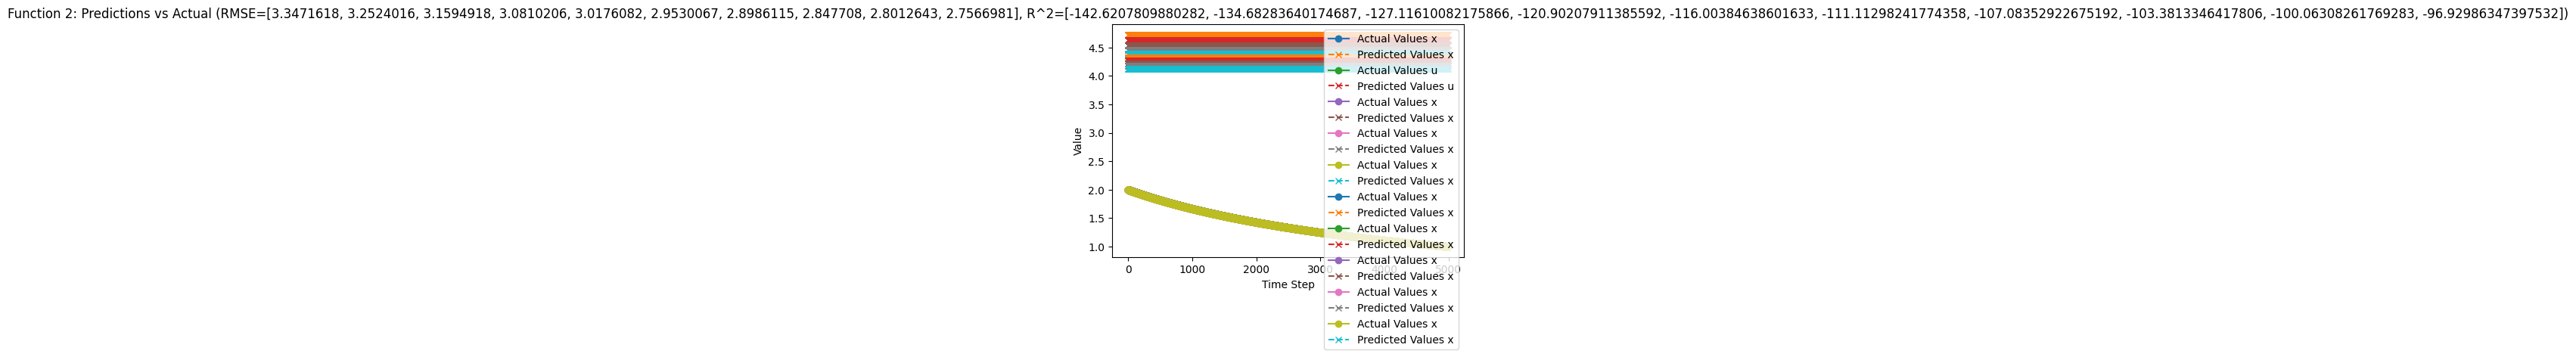

In [ ]:
#Metrics function 2
#print(val_outputs[0].squeeze(0)[1])
# print(test_array_tensor)
#rmse_r2(val_outputs[1].squeeze(0),val_ys[1].squeeze(0), 'Function 2')

function = 2
rmse, r_squared = rmse_r2(val_outputs[function-1], val_ys[function-1], f'Function {function}')
# plot_predictions_vs_actual(val_outputs[0].squeeze(0),val_inputs[0].transpose(1,2).squeeze(0),test_array_tensor[0,:,:], f'Func 1: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})')
plot_predictions_vs_actual_simple(val_outputs[function-1], val_ys[function-1], f'Function {function}: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})')


(4990, 10)
  Description     Metric           x
0  Function 3  Test RMSE    3.235920
1  Function 3    Test R² -125.133057


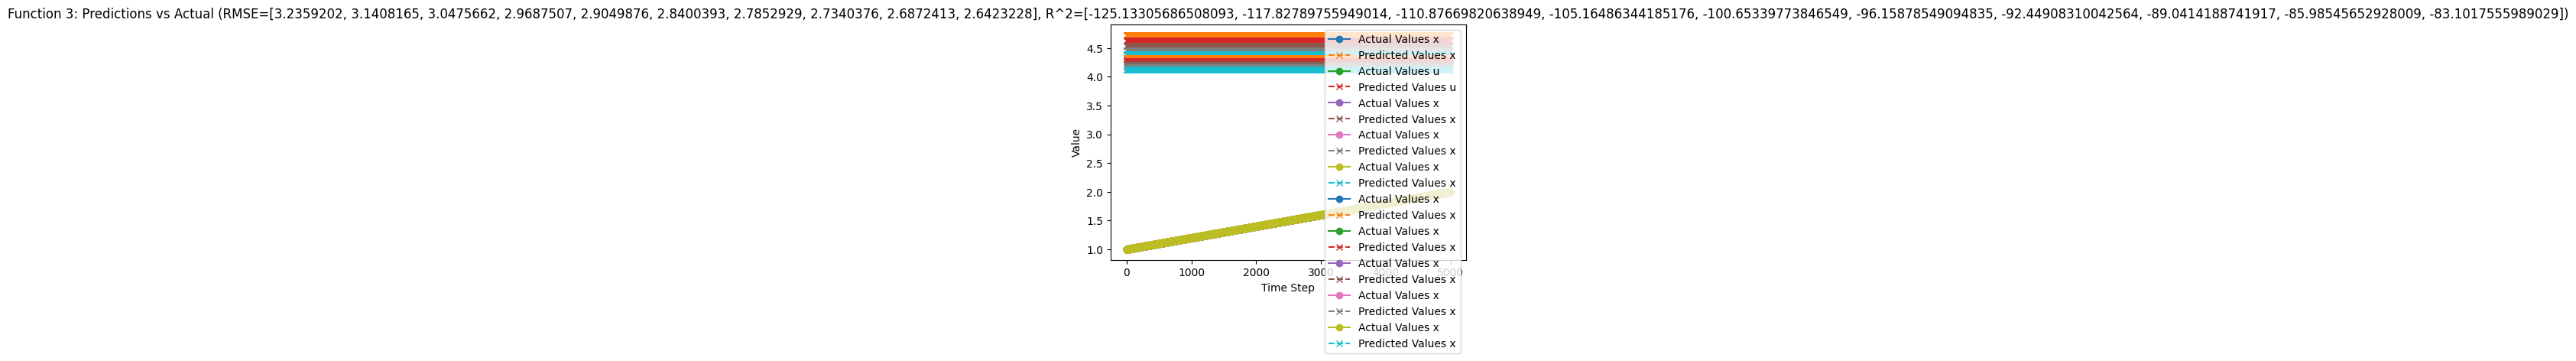

In [ ]:
#Metrics function 3

function = 3
rmse, r_squared = rmse_r2(val_outputs[function-1], val_ys[function-1], f'Function {function}')
# plot_predictions_vs_actual(val_outputs[0].squeeze(0),val_inputs[0].transpose(1,2).squeeze(0),test_array_tensor[0,:,:], f'Func 1: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})')
plot_predictions_vs_actual_simple(val_outputs[function-1], val_ys[function-1], f'Function {function}: Predictions vs Actual (RMSE={rmse}, R^2={r_squared})')
